In [1]:
import json
import seaborn as sns
import pandas as pd
from collections import Counter

sns.set()

filepath = "./artillery.log"

print("Everything is set up.")

Everything is set up.


In [2]:
with open(filepath, "r") as f:
    calls = []
    coldstarts = []

    for i, line in enumerate(f):
        # find beefas lines
        split = line.split("BEFAAS")
        if len(split) == 2:
            bline = split[1]

            csv_object = json.loads(bline)
            # flatten and clean csv object
            csv_object.pop("fn")
            try:
                csv_object["coldstart"] = csv_object["event"]["coldstart"]
                csv_object.pop("event")
                coldstarts.append(csv_object)
            except:
                csv_object["url"] = csv_object["event"]["url"].split("/dev/")[1]
                csv_object["contextId"] = csv_object["event"]["contextId"]
                csv_object["xPair"] = csv_object["event"]["xPair"]
                csv_object["type"] = csv_object["event"]["type"]
                csv_object.pop("event")
                calls.append(csv_object)

print("Number of artillery coldstarts: {0!s}".format(len(coldstarts)))
print("Number of calls: {0!s}".format(len(calls)))
# FINDING: there is only one coldstart

Number of coldstarts: 1
Number of calls: 27170


In [3]:
df_calls = pd.DataFrame(calls)

df_calls.head()

,version,deploymentId,timestamp,now,url,contextId,xPair,type
0,8.4.3,pd77smagv2eeniu6,1607630541913,1462.909536,frontend/,4jzvd52j,4jzvd52j-s6i0hlr3,before
1,8.4.3,pd77smagv2eeniu6,1607630542183,1732.909147,frontend/,jlcjv0xo,jlcjv0xo-9mtjx3db,before
2,8.4.3,pd77smagv2eeniu6,1607630542447,1997.103168,frontend/,3y9bsul7,3y9bsul7-92v2e6bw,before
3,8.4.3,pd77smagv2eeniu6,1607630542731,2280.497805,frontend/,61qranuz,61qranuz-ci0bfte5,before
4,8.4.3,pd77smagv2eeniu6,1607630543302,2851.880073,frontend/,otepgs8n,otepgs8n-95yomppe,before


<AxesSubplot:xlabel='timestamp', ylabel='now'>

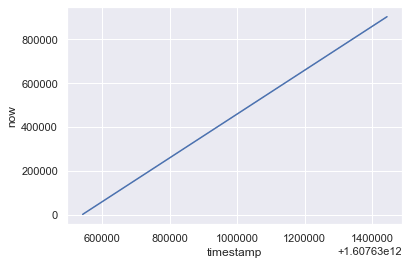

In [4]:
sns.lineplot(data=df_calls, x="timestamp", y="now")
# FINDING: timestamp and now are the same, but now has a higher granularity

In [5]:
print("Number of calls: {0!s}".format(len(df_calls)))
print("Unique deploymentId: {0!s}".format(len(df_calls["deploymentId"].unique())))
print("Unique version: {0!s}".format(len(df_calls["version"].unique())))
print("Unique timestamp: {0!s}".format(len(df_calls["timestamp"].unique())))
print("Unique now: {0!s}".format(len(df_calls["now"].unique())))
print("Unique url: {0!s}".format(len(df_calls["url"].unique())))
print("Unique contextId: {0!s}".format(len(df_calls["contextId"].unique())))
print("Unique xPair: {0!s}".format(len(df_calls["xPair"].unique())))
print("Unique type: {0!s}".format(len(df_calls["type"].unique())))

# FINDING: now is a unique key for each api call
# FINDING: there are two xPair and contextIds for each call -> one for start and one for end

Number of calls: 27170
Unique deploymentId: 1
Unique version: 1
Unique timestamp: 19932
Unique now: 27170
Unique url: 8
Unique contextId: 13585
Unique xPair: 13585
Unique type: 2


In [6]:
openCalls = {}
latencies = []

# only works if calls is sorted by "now" -> should be the case
for call in calls:
    if call["contextId"] in openCalls:
        assert call["type"] == "after"
        openCall = openCalls.pop(call["contextId"])

        latencies.append({
            "contextId": call["contextId"],
            "url": call["url"],
            "start": openCall["now"],
            "latency": call["now"] - openCall["now"]
        })
    else:
        assert call["type"] == "before"
        openCalls[call["contextId"]] = call

print("Number of completed calls: {0!s}".format(len(latencies)))
print("Number of incomplete calls: {0!s}".format(len(openCalls)))

# FINDING: every call completed

Number of completed calls: 13585
Number of incomplete calls: 0


In [7]:
df_latencies = pd.DataFrame(latencies)

df_latencies.sort_values(by=["start", "latency"], inplace=True)

df_latencies.head(10)

# FINDING: frontend/setUser wird wahrscheinlich aufgerufen, bevor frontend/ fertig ist

,contextId,url,start,latency
3,4jzvd52j,frontend/,1462.909536,2248.107621
5,jlcjv0xo,frontend/,1732.909147,2044.663550
1,3y9bsul7,frontend/,1997.103168,1628.343188
7,61qranuz,frontend/,2280.497805,1642.776155
9,otepgs8n,frontend/,2851.880073,1094.900869
15,clyal3sb,frontend/,3137.724361,1106.324282
4,wt3uokbr,frontend/,3423.742089,325.488192
0,i8fgjutr,frontend/setUser,3432.263606,90.270344
8,t9e927sn,frontend/,3523.145721,405.288939
2,zrbthkx9,frontend/setUser,3607.686218,96.900842


<AxesSubplot:xlabel='start', ylabel='latency'>

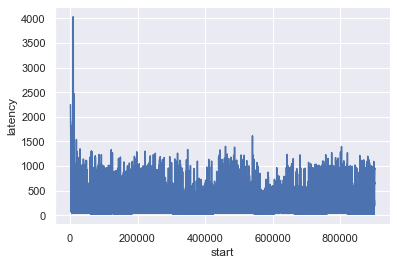

In [8]:
sns.lineplot(data=df_latencies, x="start", y="latency")
# FINDING: starts bad but stabilizes, latency in ms since experiment was 900 seconds

In [9]:
# prepeare dataframe for cdf

# create dataframe with counts per latency
df_cdf = pd.DataFrame(dict(Counter(df_latencies["latency"])), index=[0]).T
df_cdf.reset_index(inplace=True)
# rename columns
df_cdf.columns = ["Latency", "Count"]
# calculate distribution
df_cdf.sort_values(by="Latency", inplace=True)
df_cdf["cumsum"] = df_cdf["Count"].cumsum()
sum = df_cdf["Count"].sum()
df_cdf["Cumulative Distribution"] = df_cdf["cumsum"] / sum

df_cdf.head()

# FINDING: minimum latency is 17.76ms

,Latency,Count,cumsum,Cumulative Distribution
5038,17.758965,1,1,0.000074
5432,18.504729,1,2,0.000147
12498,18.618205,1,3,0.000221
10110,18.702433,1,4,0.000294
5248,18.781611,1,5,0.000368


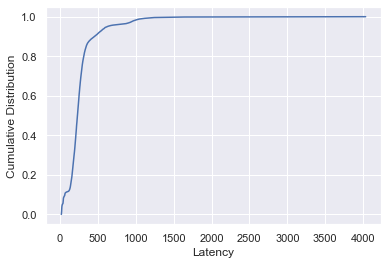

In [10]:
ax = sns.lineplot(data=df_cdf, x="Latency", y="Cumulative Distribution")

# FINDING: majority of requests needs less than 1 second and there is a longtail

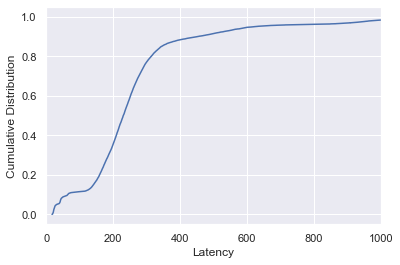

In [11]:
ax.set_xlim(0, 1000)
ax.get_figure()

# FINDING: ~70% of requests needs between ~180ms and ~380ms
# FINDING: no clear steps visible for paths